<a href="https://colab.research.google.com/github/YiqunLiu/ASPLab/blob/master/Large_scale_music_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Essentia models on the MTG-Jamendo dataset
Audio chunk: 18 (563 songs)

Model: MusiCNN, VGG

All the audio chunks, pre-trained models, manual annotations, and classification results are [here](https://drive.google.com/drive/folders/1xu5VS5_NBrCVBp4JDQjynGOtcJ-TF_Su?usp=sharing). To run this notebook, please add this file to your drive. Then run the cells below in order.

Since it's time consuming to run all the models, we also includes the model predicitons in the file above. You can skip the Model evaluation step and run the Evaluation part to see the results. 

## Preparations

In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


Install essentia with tensorflow

In [0]:
pip install --upgrade essentia-tensorflow -f https://essentia.upf.edu/python-wheels/

from essentia.standard import *

Looking in links: https://essentia.upf.edu/python-wheels/
     |████████████████████████████████| 380.7MB 47kB/s 


Download the models from the essentia website. For convenience, models are also available from Google Drive.

In [0]:
"""
# Miscellaneous: 4 MusiCNN + 4 VGGish_AudioSet
!wget https://essentia.upf.edu/models/classifiers/danceability/danceability-musicnn-msd.pb
!wget https://essentia.upf.edu/models/classifiers/gender/gender-musicnn-msd.pb
!wget https://essentia.upf.edu/models/classifiers/tonal_atonal/tonal_atonal-musicnn-msd.pb
!wget https://essentia.upf.edu/models/classifiers/voice_instrumental/voice_instrumental-musicnn-msd.pb

!wget https://essentia.upf.edu/models/classifiers/danceability/danceability-vggish-audioset.pb
!wget https://essentia.upf.edu/models/classifiers/gender/gender-vggish-audioset.pb
!wget https://essentia.upf.edu/models/classifiers/tonal_atonal/tonal_atonal-vggish-audioset.pb
!wget https://essentia.upf.edu/models/classifiers/voice_instrumental/voice_instrumental-vggish-audioset.pb

# Mood: 7 MusiCNN + 7 VGGish_AudioSet
!wget https://essentia.upf.edu/models/classifiers/mood_acoustic/mood_acoustic-musicnn-msd.pb
!wget https://essentia.upf.edu/models/classifiers/mood_aggressive/mood_aggressive-musicnn-msd.pb
!wget https://essentia.upf.edu/models/classifiers/mood_electronic/mood_electronic-musicnn-msd.pb
!wget https://essentia.upf.edu/models/classifiers/mood_happy/mood_happy-musicnn-msd.pb
!wget https://essentia.upf.edu/models/classifiers/mood_party/mood_party-musicnn-msd.pb
!wget https://essentia.upf.edu/models/classifiers/mood_relaxed/mood_relaxed-musicnn-msd.pb
!wget https://essentia.upf.edu/models/classifiers/mood_sad/mood_sad-musicnn-msd.pb

!wget https://essentia.upf.edu/models/classifiers/mood_acoustic/mood_acoustic-vggish-audioset.pb
!wget https://essentia.upf.edu/models/classifiers/mood_aggressive/mood_aggressive-vggish-audioset.pb
!wget https://essentia.upf.edu/models/classifiers/mood_electronic/mood_electronic-vggish-audioset.pb
!wget https://essentia.upf.edu/models/classifiers/mood_happy/mood_happy-vggish-audioset.pb
!wget https://essentia.upf.edu/models/classifiers/mood_party/mood_party-vggish-audioset.pb
!wget https://essentia.upf.edu/models/classifiers/mood_relaxed/mood_relaxed-vggish-audioset.pb
!wget https://essentia.upf.edu/models/classifiers/mood_sad/mood_sad-vggish-audioset.pb
"""

'\n# Miscellaneous: 4 MusiCNN + 4 VGGish_AudioSet\n!wget https://essentia.upf.edu/models/classifiers/danceability/danceability-musicnn-msd.pb\n!wget https://essentia.upf.edu/models/classifiers/gender/gender-musicnn-msd.pb\n!wget https://essentia.upf.edu/models/classifiers/tonal_atonal/tonal_atonal-musicnn-msd.pb\n!wget https://essentia.upf.edu/models/classifiers/voice_instrumental/voice_instrumental-musicnn-msd.pb\n\n!wget https://essentia.upf.edu/models/classifiers/danceability/danceability-vggish-audioset.pb\n!wget https://essentia.upf.edu/models/classifiers/gender/gender-vggish-audioset.pb\n!wget https://essentia.upf.edu/models/classifiers/tonal_atonal/tonal_atonal-vggish-audioset.pb\n!wget https://essentia.upf.edu/models/classifiers/voice_instrumental/voice_instrumental-vggish-audioset.pb\n\n# Mood: 7 MusiCNN + 7 VGGish_AudioSet\n!wget https://essentia.upf.edu/models/classifiers/mood_acoustic/mood_acoustic-musicnn-msd.pb\n!wget https://essentia.upf.edu/models/classifiers/mood_aggre

In [0]:
import numpy as np
import os
import json

audio_dir = './drive/My Drive/ASPLab_Module1/18'
model_dir = './drive/My Drive/ASPLab_Module1/model'
annotation_dir = './drive/My Drive/ASPLab_Module1/annotations'

## Model evaluation
14 models for mood classification (7 MusiCNN + 7 VGGish) and 8 models for miscellaneous classification (4 MusiCNN + 4 VGGish)

### MusiCNN for miscellaneous classification

In [0]:
class MiscellanousClassify:
  def __init__(self):
    self.danceability = TensorflowPredictMusiCNN(graphFilename=os.path.join(model_dir, 'danceability-musicnn-msd.pb'))
    self.gender = TensorflowPredictMusiCNN(graphFilename=os.path.join(model_dir, 'gender-musicnn-msd.pb'))
    self.tonal = TensorflowPredictMusiCNN(graphFilename=os.path.join(model_dir, 'tonal_atonal-musicnn-msd.pb'))
    self.voice = TensorflowPredictMusiCNN(graphFilename=os.path.join(model_dir, 'voice_instrumental-musicnn-msd.pb'))

  def classify(self, filename):
    sr = 16000
    audio = EasyLoader(filename=filename, sampleRate=sr, endTime=180)()
    da = int(np.argmax(np.mean(self.danceability(audio), axis=0))) # For the two probabilities, we take the larger one as the prediction
    ge = int(np.argmax(np.mean(self.gender(audio), axis=0)))
    to = int(np.argmax(np.mean(self.tonal(audio), axis=0)))
    vo = int(np.argmax(np.mean(self.voice(audio), axis=0)))
    miscellanous_results = {'tonal_atonal': to, 'danceability': da,
                            'voice_instrumental': vo, 'gender': ge}
    return miscellanous_results

In [0]:
data_dir =  './drive/My Drive/ASPLab_Module1/miscellanous_result_musicnn' # for saving the predicitons
miscellanous = MiscellanousClassify()
count = 0
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

for root, dirs, files in os.walk(audio_dir):
  for file in files:
    if file.endswith('.mp3'):
      count += 1
      index = file.split('.')[0]
      filename = os.path.join(root, file)
      datafile = os.path.join(data_dir, "miscellanous-" + index + "-musicnn" + "-result.json")
      # check if the song has been computed
      if os.path.exists(datafile):
        print("Already computed {}".format(file))
        continue
      
      prediction = miscellanous.classify(filename)
      
      with open(datafile, "w") as fp:
        json.dump(prediction, fp)
      if count % 10 == 0:
        print('%s audios computed' % count)

### MusiCNN for mood classification

In [0]:
class MoodClassifyMusiCNN:
  def __init__(self):
    self.acoustic = TensorflowPredictMusiCNN(graphFilename=os.path.join(model_dir, 'mood_acoustic-musicnn-msd.pb'))
    self.aggressive = TensorflowPredictMusiCNN(graphFilename=os.path.join(model_dir, 'mood_aggressive-musicnn-msd.pb'))
    self.electronic = TensorflowPredictMusiCNN(graphFilename=os.path.join(model_dir, 'mood_electronic-musicnn-msd.pb'))
    self.happy = TensorflowPredictMusiCNN(graphFilename=os.path.join(model_dir, 'mood_happy-musicnn-msd.pb'))
    self.party = TensorflowPredictMusiCNN(graphFilename=os.path.join(model_dir, 'mood_party-musicnn-msd.pb'))
    self.relaxed = TensorflowPredictMusiCNN(graphFilename=os.path.join(model_dir, 'mood_relaxed-musicnn-msd.pb'))
    self.sad = TensorflowPredictMusiCNN(graphFilename=os.path.join(model_dir, 'mood_sad-musicnn-msd.pb'))

  def classify(self, filename):
    sr = 16000
    audio = EasyLoader(filename=filename, sampleRate=sr, endTime=180)()
    acoustic = int(np.argmax(np.mean(self.acoustic(audio), axis=0)))
    aggressive = int(np.argmax(np.mean(self.aggressive(audio), axis=0)))
    electronic = int(np.argmax(np.mean(self.electronic(audio), axis=0)))
    happy = int(np.argmax(np.mean(self.happy(audio), axis=0)))
    party = int(np.argmax(np.mean(self.party(audio), axis=0)))
    relaxed = int(np.argmax(np.mean(self.relaxed(audio), axis=0)))
    sad = int(np.argmax(np.mean(self.sad(audio), axis=0)))
    mood_results = {'mood_acoustic': acoustic, 'mood_electronic': electronic, 'mood_aggressive': aggressive, 
                            'mood_relaxed': relaxed, 'mood_happy': happy, 'mood_sad': sad, 'mood_party': party}
    return mood_results

In [0]:
data_dir =  './drive/My Drive/ASPLab_Module1/mood_result_musicnn'
mood = MoodClassifyMusiCNN()
count = 0
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

for root, dirs, files in os.walk(audio_dir):
  for file in files:
    if file.endswith('.mp3'):
      count += 1
      index = file.split('.')[0]
      filename = os.path.join(root, file)
      datafile = os.path.join(data_dir, "mood-" + index + "-musicnn" + "-result.json")
      if os.path.exists(datafile):
        print("Already computed {}".format(file))
        continue
      
      prediction = mood.classify(filename)
      
      with open(datafile, "w") as fp:
        json.dump(prediction, fp)
      if count % 10 == 0:
        print('%s audios computed' % count)

### VGGish for miscellaneous classification

In [0]:
class MiscellanousClassifyVGG:
  def __init__(self):
    self.danceability = TensorflowPredictVGGish(graphFilename=os.path.join(model_dir, 'danceability-vggish-audioset.pb'))
    self.gender = TensorflowPredictVGGish(graphFilename=os.path.join(model_dir, 'gender-vggish-audioset.pb'))
    self.tonal = TensorflowPredictVGGish(graphFilename=os.path.join(model_dir, 'tonal_atonal-vggish-audioset.pb'))
    self.voice = TensorflowPredictVGGish(graphFilename=os.path.join(model_dir, 'voice_instrumental-vggish-audioset.pb'))

  def classify(self, filename):
    sr = 16000
    audio = EasyLoader(filename=filename, sampleRate=sr, endTime=180)()
    da = int(np.argmax(np.mean(self.danceability(audio), axis=0)))
    ge = int(np.argmax(np.mean(self.gender(audio), axis=0)))
    to = int(np.argmax(np.mean(self.tonal(audio), axis=0)))
    vo = int(np.argmax(np.mean(self.voice(audio), axis=0)))
    miscellanous_results = {'tonal_atonal': to, 'danceability': da,
                            'voice_instrumental': vo, 'gender': ge}
    return miscellanous_results

In [0]:
data_dir =  './drive/My Drive/ASPLab_Module1/miscellanous_result_vggish'
miscellanous = MiscellanousClassifyVGG()
count = 0
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

for root, dirs, files in os.walk(audio_dir):
  for file in files:
    if file.endswith('.mp3'):
      count += 1
      index = file.split('.')[0]
      filename = os.path.join(root, file)
      datafile = os.path.join(data_dir, "miscellanous-" + index + "-vggish" + "-result.json")
      if os.path.exists(datafile):
        print("Already computed {}".format(file))
        continue
      
      prediction = miscellanous.classify(filename)
      
      with open(datafile, "w") as fp:
        json.dump(prediction, fp)
      if count % 10 == 0:
        print('%s audios computed' % count)

### VGGish for mood classification

In [0]:
class MoodClassifyVGG:
  def __init__(self):
    self.acoustic = TensorflowPredictVGGish(graphFilename=os.path.join(model_dir, 'mood_acoustic-vggish-audioset.pb'))
    self.aggressive = TensorflowPredictVGGish(graphFilename=os.path.join(model_dir, 'mood_aggressive-vggish-audioset.pb'))
    self.electronic = TensorflowPredictVGGish(graphFilename=os.path.join(model_dir, 'mood_electronic-vggish-audioset.pb'))
    self.happy = TensorflowPredictVGGish(graphFilename=os.path.join(model_dir, 'mood_happy-vggish-audioset.pb'))
    self.party = TensorflowPredictVGGish(graphFilename=os.path.join(model_dir, 'mood_party-vggish-audioset.pb'))
    self.relaxed = TensorflowPredictVGGish(graphFilename=os.path.join(model_dir, 'mood_relaxed-vggish-audioset.pb'))
    self.sad = TensorflowPredictVGGish(graphFilename=os.path.join(model_dir, 'mood_sad-vggish-audioset.pb'))

  def classify(self, filename):
    sr = 16000
    audio = EasyLoader(filename=filename, sampleRate=sr, endTime=180)()
    acoustic = int(np.argmax(np.mean(self.acoustic(audio), axis=0)))
    aggressive = int(np.argmax(np.mean(self.aggressive(audio), axis=0)))
    electronic = int(np.argmax(np.mean(self.electronic(audio), axis=0)))
    happy = int(np.argmax(np.mean(self.happy(audio), axis=0)))
    party = int(np.argmax(np.mean(self.party(audio), axis=0)))
    relaxed = int(np.argmax(np.mean(self.relaxed(audio), axis=0)))
    sad = int(np.argmax(np.mean(self.sad(audio), axis=0)))
    mood_results = {'mood_acoustic': acoustic, 'mood_electronic': electronic, 'mood_aggressive': aggressive, 
                            'mood_relaxed': relaxed, 'mood_happy': happy, 'mood_sad': sad, 'mood_party': party}
    return mood_results

In [0]:
data_dir =  './drive/My Drive/ASPLab_Module1/mood_result_vggish'
mood = MoodClassifyVGG()
count = 0
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

for root, dirs, files in os.walk(audio_dir):
  for file in files:
    if file.endswith('.mp3'):
      count += 1
      index = file.split('.')[0]
      filename = os.path.join(root, file)
      datafile = os.path.join(data_dir, "mood-" + index + "-vggish" + "-result.json")
      if os.path.exists(datafile):
        print("Already computed {}".format(file))
        continue
      
      prediction = mood.classify(filename)
      
      with open(datafile, "w") as fp:
        json.dump(prediction, fp)
      if count % 10 == 0:
        print('%s audios computed' % count)

## Evaluation
The annotation classes for each task are shown below:

| Tasks              | Manual classes               | Model classes                |
|--------------------|------------------------------|------------------------------|
| mood_acoustic      | [non_acoustic, acoustic]     | [acoustic, non_acoustic]     |
| mood_electronic    | [non_electronic, electronic] | [electronic, non_electronic] |
| mood_aggresive     | [not_aggressive, aggresive]  | [aggresive, not_aggresive]   |
| mood-relaxed       | [non_relaxed, relaxed]       | [relaxed, non_relaxed]       |
| mood_happy         | [non_happy, happy]           | [happy, non-happy]           |
| mood_sad           | [non_sad, sad]               | [sad, non_sad]               |
| mood_party         | [non_party, party]           | [party, non_party]           |
| tonal_atonal       | [atonal, tonal]              | [atonal, tonal]              |
| daceability        | [not_danceable, danceable]   | [danceable, not_danceable]   |
| voice_instrumental | [instrumental, voice]        | [instrumental, voice]        |
| gender             | [male, femal, instrumental]  | [female, male]               |

In [0]:
import sklearn.metrics
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

mood_musicnn_dir =  './drive/My Drive/ASPLab_Module1/mood_result_musicnn'
mood_vgg_dir =  './drive/My Drive/ASPLab_Module1/mood_result_vggish'
miscellaneous_musicnn_dir =  './drive/My Drive/ASPLab_Module1/miscellanous_result_musicnn'
miscellaneous_vgg_dir =  './drive/My Drive/ASPLab_Module1/miscellanous_result_vggish'
figure_dir =  './drive/My Drive/ASPLab_Module1/figure'
if not os.path.exists(figure_dir):
    os.mkdir(figure_dir)

In [0]:
# define a fuction to plot the confusion matrices of MusiCNN and VGGish for each task
def plot_confusion_matrix(true, pred_musicnn, pred_vgg, classes, task_name):
  conf_mat = pd.DataFrame(confusion_matrix(true, pred_musicnn), columns = classes, index = classes)
  conf_mat.index.name = 'Actual'
  conf_mat.columns.name = 'Predicted'
  plt.figure(figsize = (7, 5))
  sns.set(font_scale = 1.2)
  ax = plt.axes()
  cm = sns.heatmap(conf_mat, cmap = "Blues", annot = True, fmt = 'd', ax = ax)
  ax.set_title(task_name+'_MusiCNN')
  save_cm = cm.get_figure()
  save_cm.savefig(os.path.join(figure_dir, task_name+'MusiCNN.png'))

  conf_mat = pd.DataFrame(confusion_matrix(true, pred_vgg), columns = classes, index = classes)
  conf_mat.index.name = 'Actual'
  conf_mat.columns.name = 'Predicted'
  plt.figure(figsize = (7, 5))
  sns.set(font_scale = 1.2)
  ax = plt.axes()
  cm = sns.heatmap(conf_mat, cmap = "Blues", annot = True, fmt = 'd', ax = ax)
  ax.set_title(task_name+'_VGG')
  save_cm = cm.get_figure()
  save_cm.savefig(os.path.join(figure_dir, task_name+'VGG.png'))

### Task1: mood_acoustic

In [0]:
task_name = 'mood_acoustic'
classes = ['acoustic', 'non_acoustic']
true = []
pred_musicnn = []
pred_vgg = []

count = 0
for root, dirs, files in os.walk(annotation_dir):
  for file in files:
    if file.startswith('mood'):
      count += 1
      index = file.split('_')[1][:-9]
      with open(os.path.join(root, file)) as f1:
        manual_annotation = json.load(f1)
      if manual_annotation['mood_acoustic'] == '0':
        true.append('non_acoustic')
      elif manual_annotation['mood_acoustic'] == '1':
        true.append('acoustic')
      
      with open(os.path.join(mood_musicnn_dir, 'mood-'+index+'-musicnn-result.json')) as f2:
        musicnn_annotation = json.load(f2)
      if musicnn_annotation['mood_acoustic'] == 0:
        pred_musicnn.append('acoustic')
      elif musicnn_annotation['mood_acoustic'] == 1:
        pred_musicnn.append('non_acoustic')
      
      with open(os.path.join(mood_vgg_dir, 'mood-'+index+'-vggish-result.json')) as f3:
        vgg_annotation = json.load(f3)
      if vgg_annotation['mood_acoustic'] == 0:
        pred_vgg.append('acoustic')
      elif vgg_annotation['mood_acoustic'] == 1:
        pred_vgg.append('non_acoustic')

      if count % 100 == 0:
        print('%s files computed' % count)

100 files computed
200 files computed
300 files computed
400 files computed
500 files computed


MusiCNN_accuracy: 0.7211
VGGish_accuracy: 0.8117


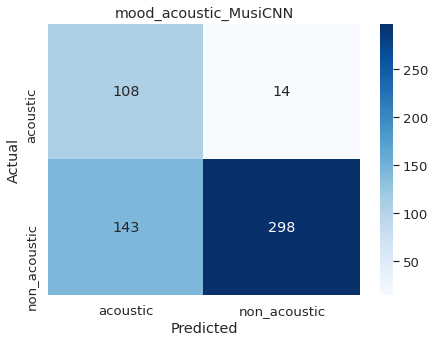

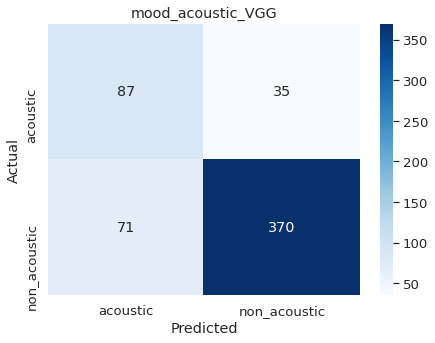

In [0]:
print("MusiCNN_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_musicnn))
print("VGGish_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_vgg))
plot_confusion_matrix(true, pred_musicnn, pred_vgg, classes, task_name)

### Task2: mood_electronic

In [0]:
task_name = 'mood_electronic'
classes = ['electronic', 'non_electronic']
true = []
pred_musicnn = []
pred_vgg = []

count = 0
for root, dirs, files in os.walk(annotation_dir):
  for file in files:
    if file.startswith('mood'):
      count += 1
      index = file.split('_')[1][:-9]
      with open(os.path.join(root, file)) as f1:
        manual_annotation = json.load(f1)
      if manual_annotation['mood_electronic'] == '0':
        true.append('non_electronic')
      elif manual_annotation['mood_electronic'] == '1':
        true.append('electronic')
      
      with open(os.path.join(mood_musicnn_dir, 'mood-'+index+'-musicnn-result.json')) as f2:
        musicnn_annotation = json.load(f2)
      if musicnn_annotation['mood_electronic'] == 0:
        pred_musicnn.append('electronic')
      elif musicnn_annotation['mood_electronic'] == 1:
        pred_musicnn.append('non_electronic')
      
      with open(os.path.join(mood_vgg_dir, 'mood-'+index+'-vggish-result.json')) as f3:
        vgg_annotation = json.load(f3)
      if vgg_annotation['mood_electronic'] == 0:
        pred_vgg.append('electronic')
      elif vgg_annotation['mood_electronic'] == 1:
        pred_vgg.append('non_electronic')

      if count % 100 == 0:
        print('%s files computed' % count)

100 files computed
200 files computed
300 files computed
400 files computed
500 files computed


MusiCNN_accuracy: 0.8135
VGGish_accuracy: 0.8348


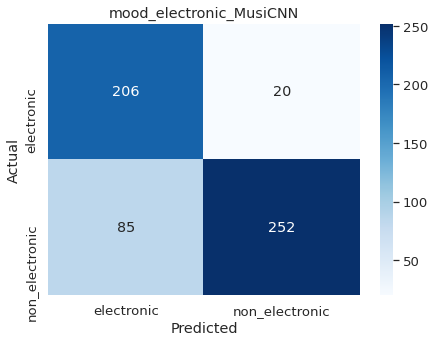

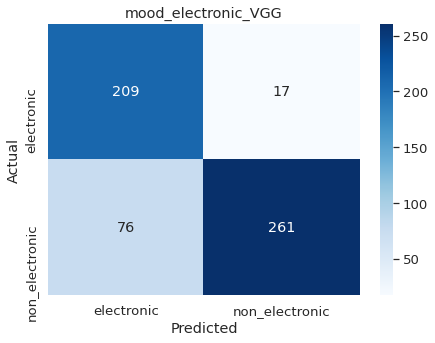

In [0]:
print("MusiCNN_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_musicnn))
print("VGGish_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_vgg))
plot_confusion_matrix(true, pred_musicnn, pred_vgg, classes, task_name)

### Task3: mood_aggressive

In [0]:
task_name = 'mood_aggressive'
classes = ['aggressive', 'non_aggressive']
true = []
pred_musicnn = []
pred_vgg = []

count = 0
for root, dirs, files in os.walk(annotation_dir):
  for file in files:
    if file.startswith('mood'):
      count += 1
      index = file.split('_')[1][:-9]
      with open(os.path.join(root, file)) as f1:
        manual_annotation = json.load(f1)
      if manual_annotation['mood_aggressive'] == '0':
        true.append('non_aggressive')
      elif manual_annotation['mood_aggressive'] == '1':
        true.append('aggressive')
      
      with open(os.path.join(mood_musicnn_dir, 'mood-'+index+'-musicnn-result.json')) as f2:
        musicnn_annotation = json.load(f2)
      if musicnn_annotation['mood_aggressive'] == 0:
        pred_musicnn.append('aggressive')
      elif musicnn_annotation['mood_aggressive'] == 1:
        pred_musicnn.append('non_aggressive')
      
      with open(os.path.join(mood_vgg_dir, 'mood-'+index+'-vggish-result.json')) as f3:
        vgg_annotation = json.load(f3)
      if vgg_annotation['mood_aggressive'] == 0:
        pred_vgg.append('aggressive')
      elif vgg_annotation['mood_aggressive'] == 1:
        pred_vgg.append('non_aggressive')

      if count % 100 == 0:
        print('%s files computed' % count)

100 files computed
200 files computed
300 files computed
400 files computed
500 files computed


MusiCNN_accuracy: 0.9147
VGGish_accuracy: 0.8774


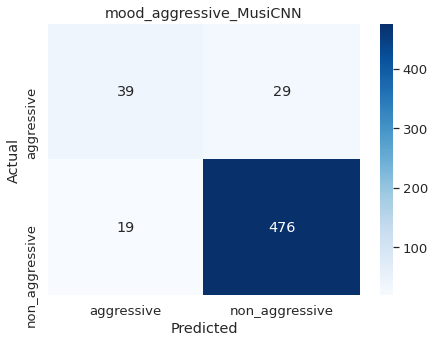

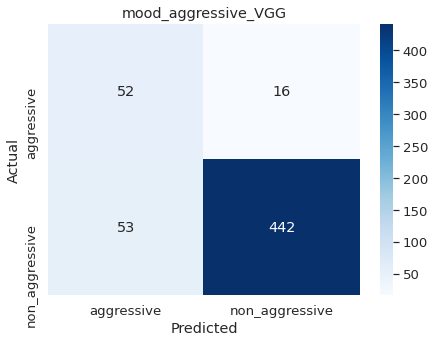

In [0]:
print("MusiCNN_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_musicnn))
print("VGGish_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_vgg))
plot_confusion_matrix(true, pred_musicnn, pred_vgg, classes, task_name)

### Task4: mood_relaxed

In [0]:
task_name = 'mood_relaxed'
classes = ['relaxed', 'non_relaxed']
true = []
pred_musicnn = []
pred_vgg = []

count = 0
for root, dirs, files in os.walk(annotation_dir):
  for file in files:
    if file.startswith('mood'):
      count += 1
      index = file.split('_')[1][:-9]
      with open(os.path.join(root, file)) as f1:
        manual_annotation = json.load(f1)
      if manual_annotation['mood_relaxed'] == '0':
        true.append('non_relaxed')
      elif manual_annotation['mood_relaxed'] == '1':
        true.append('relaxed')
      
      with open(os.path.join(mood_musicnn_dir, 'mood-'+index+'-musicnn-result.json')) as f2:
        musicnn_annotation = json.load(f2)
      if musicnn_annotation['mood_relaxed'] == 0:
        pred_musicnn.append('relaxed')
      elif musicnn_annotation['mood_relaxed'] == 1:
        pred_musicnn.append('non_relaxed')
      
      with open(os.path.join(mood_vgg_dir, 'mood-'+index+'-vggish-result.json')) as f3:
        vgg_annotation = json.load(f3)
      if vgg_annotation['mood_relaxed'] == 0:
        pred_vgg.append('relaxed')
      elif vgg_annotation['mood_relaxed'] == 1:
        pred_vgg.append('non_relaxed')

      if count % 100 == 0:
        print('%s files computed' % count)

100 files computed
200 files computed
300 files computed
400 files computed
500 files computed


MusiCNN_accuracy: 0.3943
VGGish_accuracy: 0.2948


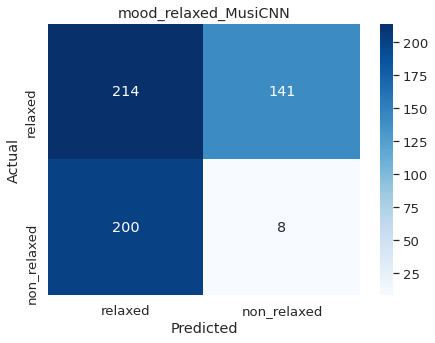

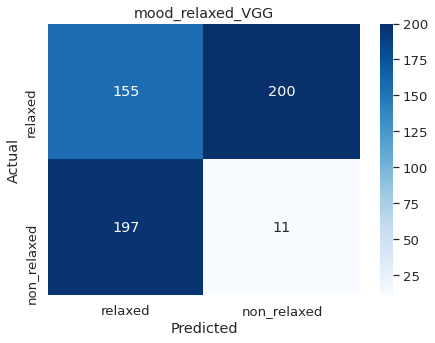

In [0]:
print("MusiCNN_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_musicnn))
print("VGGish_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_vgg))
plot_confusion_matrix(true, pred_musicnn, pred_vgg, classes, task_name)

### Task5: mood_happy

In [0]:
task_name = 'mood_happy'
classes = ['happy', 'non_happy']
true = []
pred_musicnn = []
pred_vgg = []

count = 0
for root, dirs, files in os.walk(annotation_dir):
  for file in files:
    if file.startswith('mood'):
      count += 1
      index = file.split('_')[1][:-9]
      with open(os.path.join(root, file)) as f1:
        manual_annotation = json.load(f1)
      if manual_annotation['mood_happy'] == '0':
        true.append('non_happy')
      elif manual_annotation['mood_happy'] == '1':
        true.append('happy')
      
      with open(os.path.join(mood_musicnn_dir, 'mood-'+index+'-musicnn-result.json')) as f2:
        musicnn_annotation = json.load(f2)
      if musicnn_annotation['mood_happy'] == 0:
        pred_musicnn.append('happy')
      elif musicnn_annotation['mood_happy'] == 1:
        pred_musicnn.append('non_happy')
      
      with open(os.path.join(mood_vgg_dir, 'mood-'+index+'-vggish-result.json')) as f3:
        vgg_annotation = json.load(f3)
      if vgg_annotation['mood_happy'] == 0:
        pred_vgg.append('happy')
      elif vgg_annotation['mood_happy'] == 1:
        pred_vgg.append('non_happy')

      if count % 100 == 0:
        print('%s files computed' % count)

100 files computed
200 files computed
300 files computed
400 files computed
500 files computed


MusiCNN_accuracy: 0.7513
VGGish_accuracy: 0.7655


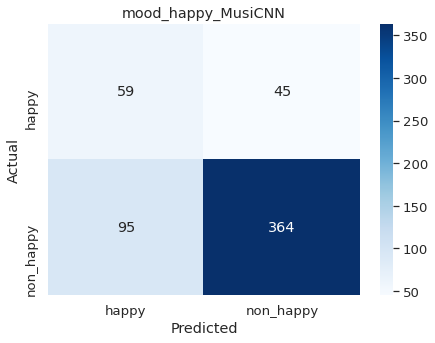

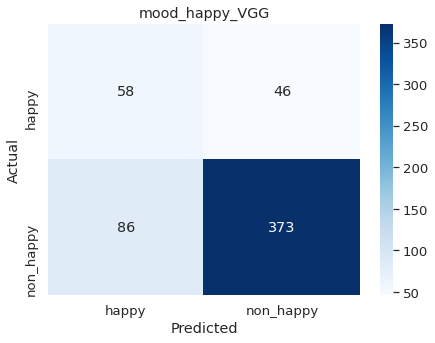

In [0]:
print("MusiCNN_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_musicnn))
print("VGGish_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_vgg))
plot_confusion_matrix(true, pred_musicnn, pred_vgg, classes, task_name)

### Task6: mood_sad

In [0]:
task_name = 'mood_sad'
classes = ['sad', 'non_sad']
true = []
pred_musicnn = []
pred_vgg = []

count = 0
for root, dirs, files in os.walk(annotation_dir):
  for file in files:
    if file.startswith('mood'):
      count += 1
      index = file.split('_')[1][:-9]
      with open(os.path.join(root, file)) as f1:
        manual_annotation = json.load(f1)
      if manual_annotation['mood_sad'] == '0':
        true.append('non_sad')
      elif manual_annotation['mood_sad'] == '1':
        true.append('sad')
      
      with open(os.path.join(mood_musicnn_dir, 'mood-'+index+'-musicnn-result.json')) as f2:
        musicnn_annotation = json.load(f2)
      if musicnn_annotation['mood_sad'] == 0:
        pred_musicnn.append('sad')
      elif musicnn_annotation['mood_sad'] == 1:
        pred_musicnn.append('non_sad')
      
      with open(os.path.join(mood_vgg_dir, 'mood-'+index+'-vggish-result.json')) as f3:
        vgg_annotation = json.load(f3)
      if vgg_annotation['mood_sad'] == 0:
        pred_vgg.append('sad')
      elif vgg_annotation['mood_sad'] == 1:
        pred_vgg.append('non_sad')

      if count % 100 == 0:
        print('%s files computed' % count)

100 files computed
200 files computed
300 files computed
400 files computed
500 files computed


MusiCNN_accuracy: 0.3837
VGGish_accuracy: 0.3659


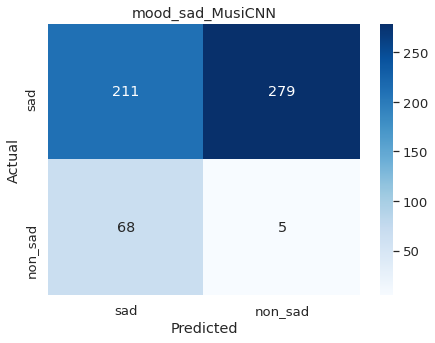

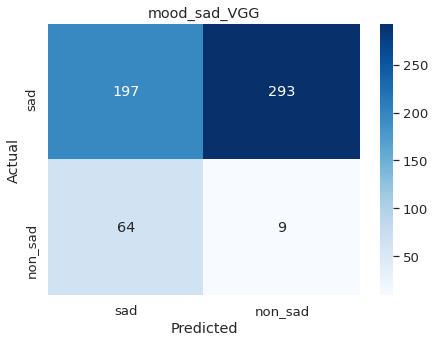

In [0]:
print("MusiCNN_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_musicnn))
print("VGGish_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_vgg))
plot_confusion_matrix(true, pred_musicnn, pred_vgg, classes, task_name)

### Task7: mood_party

In [0]:
task_name = 'mood_party'
classes = ['party', 'non_party']
true = []
pred_musicnn = []
pred_vgg = []

count = 0
for root, dirs, files in os.walk(annotation_dir):
  for file in files:
    if file.startswith('mood'):
      count += 1
      index = file.split('_')[1][:-9]
      with open(os.path.join(root, file)) as f1:
        manual_annotation = json.load(f1)
      if manual_annotation['mood_party'] == '0':
        true.append('non_party')
      elif manual_annotation['mood_party'] == '1':
        true.append('party')
      
      with open(os.path.join(mood_musicnn_dir, 'mood-'+index+'-musicnn-result.json')) as f2:
        musicnn_annotation = json.load(f2)
      if musicnn_annotation['mood_party'] == 0:
        pred_musicnn.append('party')
      elif musicnn_annotation['mood_party'] == 1:
        pred_musicnn.append('non_party')
      
      with open(os.path.join(mood_vgg_dir, 'mood-'+index+'-vggish-result.json')) as f3:
        vgg_annotation = json.load(f3)
      if vgg_annotation['mood_party'] == 0:
        pred_vgg.append('party')
      elif vgg_annotation['mood_party'] == 1:
        pred_vgg.append('non_party')

      if count % 100 == 0:
        print('%s files computed' % count)

100 files computed
200 files computed
300 files computed
400 files computed
500 files computed


MusiCNN_accuracy: 0.1883
VGGish_accuracy: 0.1829


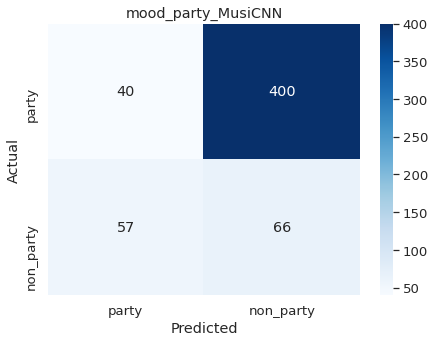

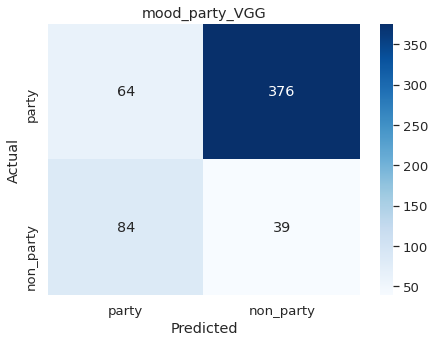

In [0]:
print("MusiCNN_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_musicnn))
print("VGGish_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_vgg))
plot_confusion_matrix(true, pred_musicnn, pred_vgg, classes, task_name)

### Task8: tonal_atonal

In [0]:
task_name = 'tonal_atonal'
classes = ['atonal', 'tonal']
true = []
pred_musicnn = []
pred_vgg = []

count = 0
for root, dirs, files in os.walk(annotation_dir):
  for file in files:
    if file.startswith('miscellaneous'):
      count += 1
      index = file.split('_')[1][:-9]
      with open(os.path.join(root, file)) as f1:
        manual_annotation = json.load(f1)
      if manual_annotation['tonal_atonal'] == '0':
        true.append('atonal')
      elif manual_annotation['tonal_atonal'] == '1':
        true.append('tonal')
      
      with open(os.path.join(miscellaneous_musicnn_dir, 'miscellanous-'+index+'-musicnn-result.json')) as f2:
        musicnn_annotation = json.load(f2)
      if musicnn_annotation['tonal_atonal'] == 0:
        pred_musicnn.append('atonal')
      elif musicnn_annotation['tonal_atonal'] == 1:
        pred_musicnn.append('tonal')
      
      with open(os.path.join(miscellaneous_vgg_dir, 'miscellanous-'+index+'-vggish-result.json')) as f3:
        vgg_annotation = json.load(f3)
      if vgg_annotation['tonal_atonal'] == 0:
        pred_vgg.append('atonal')
      elif vgg_annotation['tonal_atonal'] == 1:
        pred_vgg.append('tonal')

      if count % 100 == 0:
        print('%s files computed' % count)

100 files computed
200 files computed
300 files computed
400 files computed
500 files computed


MusiCNN_accuracy: 0.2114
VGGish_accuracy: 0.4085


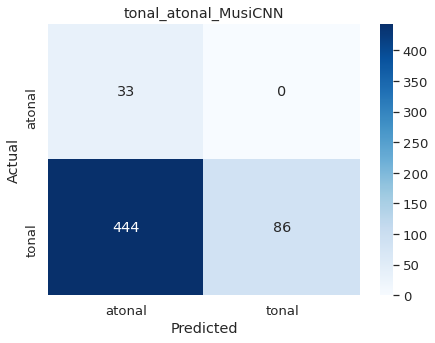

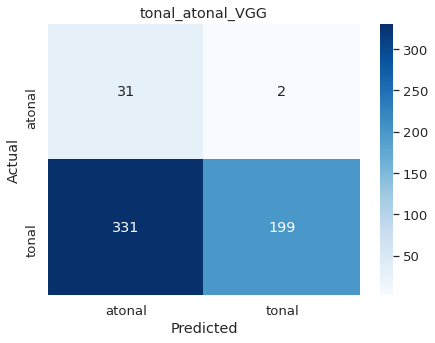

In [0]:
print("MusiCNN_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_musicnn))
print("VGGish_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_vgg))
plot_confusion_matrix(true, pred_musicnn, pred_vgg, classes, task_name)

### Task9: danceability

In [0]:
task_name = 'danceability'
classes = ['danceable', 'not_danceable']
true = []
pred_musicnn = []
pred_vgg = []

count = 0
for root, dirs, files in os.walk(annotation_dir):
  for file in files:
    if file.startswith('miscellaneous'):
      count += 1
      index = file.split('_')[1][:-9]
      with open(os.path.join(root, file)) as f1:
        manual_annotation = json.load(f1)
      if manual_annotation['danceability'] == '0':
        true.append('not_danceable')
      elif manual_annotation['danceability'] == '1':
        true.append('danceable')
      
      with open(os.path.join(miscellaneous_musicnn_dir, 'miscellanous-'+index+'-musicnn-result.json')) as f2:
        musicnn_annotation = json.load(f2)
      if musicnn_annotation['danceability'] == 0:
        pred_musicnn.append('danceable')
      elif musicnn_annotation['danceability'] == 1:
        pred_musicnn.append('not_danceable')
      
      with open(os.path.join(miscellaneous_vgg_dir, 'miscellanous-'+index+'-vggish-result.json')) as f3:
        vgg_annotation = json.load(f3)
      if vgg_annotation['danceability'] == 0:
        pred_vgg.append('danceable')
      elif vgg_annotation['danceability'] == 1:
        pred_vgg.append('not_danceable')

      if count % 100 == 0:
        print('%s files computed' % count)

100 files computed
200 files computed
300 files computed
400 files computed
500 files computed


MusiCNN_accuracy: 0.6448
VGGish_accuracy: 0.6821


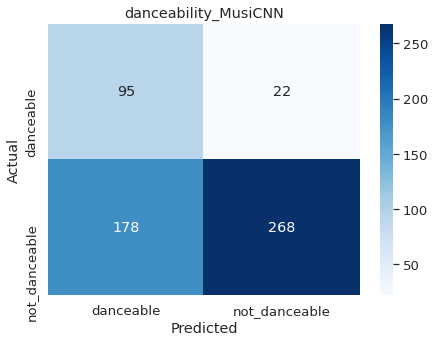

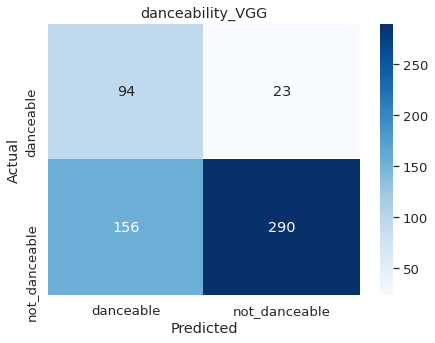

In [0]:
print("MusiCNN_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_musicnn))
print("VGGish_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_vgg))
plot_confusion_matrix(true, pred_musicnn, pred_vgg, classes, task_name)

### Task10: voice_instrumental

In [0]:
task_name = 'voice_instrumental'
classes = ['instrumental', 'voice']
true = []
pred_musicnn = []
pred_vgg = []

count = 0
for root, dirs, files in os.walk(annotation_dir):
  for file in files:
    if file.startswith('miscellaneous'):
      count += 1
      index = file.split('_')[1][:-9]
      with open(os.path.join(root, file)) as f1:
        manual_annotation = json.load(f1)
      if manual_annotation['voice_instrumental'] == '0':
        true.append('instrumental')
      elif manual_annotation['voice_instrumental'] == '1':
        true.append('voice')
      
      with open(os.path.join(miscellaneous_musicnn_dir, 'miscellanous-'+index+'-musicnn-result.json')) as f2:
        musicnn_annotation = json.load(f2)
      if musicnn_annotation['voice_instrumental'] == 0:
        pred_musicnn.append('instrumental')
      elif musicnn_annotation['voice_instrumental'] == 1:
        pred_musicnn.append('voice')
      
      with open(os.path.join(miscellaneous_vgg_dir, 'miscellanous-'+index+'-vggish-result.json')) as f3:
        vgg_annotation = json.load(f3)
      if vgg_annotation['voice_instrumental'] == 0:
        pred_vgg.append('instrumental')
      elif vgg_annotation['voice_instrumental'] == 1:
        pred_vgg.append('voice')

      if count % 100 == 0:
        print('%s files computed' % count)

100 files computed
200 files computed
300 files computed
400 files computed
500 files computed


MusiCNN_accuracy: 0.8455
VGGish_accuracy: 0.8579


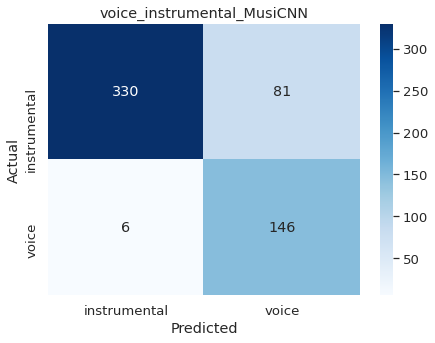

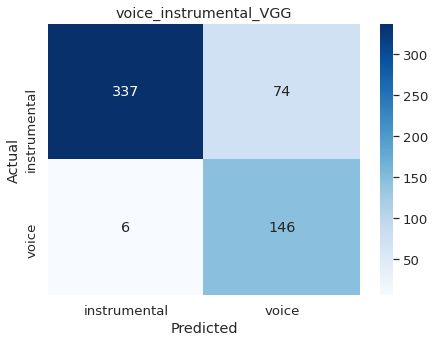

In [0]:
print("MusiCNN_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_musicnn))
print("VGGish_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_vgg))
plot_confusion_matrix(true, pred_musicnn, pred_vgg, classes, task_name)

### Task11: gender

In [0]:
task_name = 'gender'
classes = ['female', 'male']
true = []
pred_musicnn = []
pred_vgg = []

count = 0
for root, dirs, files in os.walk(annotation_dir):
  for file in files:
    if file.startswith('miscellaneous'):
      index = file.split('_')[1][:-9]
      with open(os.path.join(root, file)) as f1:
        manual_annotation = json.load(f1)
      if manual_annotation['gender'] == '0':
        true.append('male')
      elif manual_annotation['gender'] == '1':
        true.append('female')
      elif manual_annotation['gender'] == '2':
        continue
      
      count += 1
      with open(os.path.join(miscellaneous_musicnn_dir, 'miscellanous-'+index+'-musicnn-result.json')) as f2:
        musicnn_annotation = json.load(f2)
      if musicnn_annotation['gender'] == 0:
        pred_musicnn.append('female')
      elif musicnn_annotation['gender'] == 1:
        pred_musicnn.append('male')
      
      with open(os.path.join(miscellaneous_vgg_dir, 'miscellanous-'+index+'-vggish-result.json')) as f3:
        vgg_annotation = json.load(f3)
      if vgg_annotation['gender'] == 0:
        pred_vgg.append('female')
      elif vgg_annotation['gender'] == 1:
        pred_vgg.append('male')

      if count % 100 == 0:
        print('%s files computed' % count)

100 files computed


MusiCNN_accuracy: 0.9342
VGGish_accuracy: 0.8421


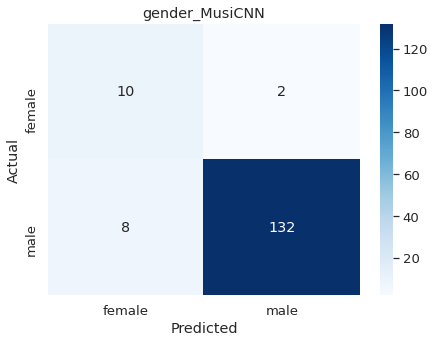

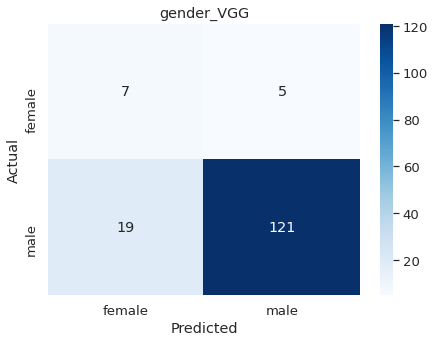

In [0]:
print("MusiCNN_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_musicnn))
print("VGGish_accuracy: %.4f" % sklearn.metrics.accuracy_score(true, pred_vgg))
plot_confusion_matrix(true, pred_musicnn, pred_vgg, classes, task_name)

### Results
The accuracies of the two models for each task are shown below:

| Tasks              | MusiCNN accuracy | VGGish accuracy |
|--------------------|------------------|-----------------|
| mood_acoustic      | 0.7211           | 0.8117          |
| mood_electronic    | 0.8135           | 0.8348          |
| mood_aggressive     | 0.9147           | 0.8774          |
| mood-relaxed       | 0.3943           | 0.2948          |
| mood_happy         | 0.7513           | 0.7655          |
| mood_sad           | 0.3837           | 0.3659          |
| mood_party         | 0.1883           | 0.1829          |
| tonal_atonal       | 0.2114           | 0.4085          |
| danceability        | 0.6448           | 0.6821          |
| voice_instrumental | 0.8455           | 0.8579          |
| gender             | 0.9342           | 0.8421          |